# DistilBert

### Import necessary packages

In [1]:
import numpy as np
import mlflow
import logging 
import torch 
import config 
import os 
from mlflow.sklearn import save_model
from transformers import AutoModelForSequenceClassification, AutoConfig

# import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import(
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics,
    get_error_analysis,
    print_error_df
)

### Setup

In [3]:
MODEL_NAME = "distilbert-base-uncased" # pulls the general-purpose DistilBERT model
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [4]:
# DATA_PATH = "../data/data_small.csv"
DATA_PATH = "../data/data_binary.csv" # uncomment this when checking that everything is just running properly. 
MODEL_PATH = "distilbert-base-uncased"
MODEL_TRAINING_PATH ="distilbert-base-uncased"
OUTPUT_DIR = "../models/distilbert_binary/trainer_output"
SAVE_PATH = "../models/distilbert_binary/pytorch_model"

### Get data

In [5]:
train_dataset, test_dataset, encoded_train_dataset, encoded_test_dataset, le = get_encode_tokenize_data("binary", DATA_PATH, MODEL_PATH)

INFO:basic_functions:Loading data...
INFO:basic_functions:Train test split, test-size 0.3
INFO:root:Create encoded dataframes
INFO:root:Encode the label column
INFO:root:Tokenize
INFO:basic_functions:create tokenizer & load model
INFO:basic_functions:create tokenizer & load model
INFO:root:Create TextDatasets (train & test)


In [6]:
y_train = encoded_train_dataset['two_class_target']

### Model Initialization

In [7]:
learning_rate= 3e-5
weight_decay= 0.01
num_train_epochs= 4
evaluation_strategy= 'epoch'
class_weight=True
dropout= 0.3


params = {
      "learning_rate": learning_rate,
      "weight_decay": weight_decay,
      "num_train_epochs": num_train_epochs,
      "evaluation_strategy": evaluation_strategy,
      "class_weight":class_weight,
      "dropout": dropout,
      "dataset": DATA_PATH
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "Distilbert Binary")
mlflow.log_params(params)

Active run_id: 265ec4ae59074e9eb7b92ca9fa753385


In [8]:
num_classes = len(np.unique(y_train))
num_classes

2

In [9]:
# Load config and set dropout
config = AutoConfig.from_pretrained(MODEL_TRAINING_PATH)
config.num_labels = num_classes # Set number of labels for classification
config.dropout = dropout # Set dropout, default is 0.1

# Load model with updated config
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_TRAINING_PATH,
    config=config  # Pass modified config
)

# model.gradient_checkpointing_enable() 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
trainer = createTrainer(
    model= model, 
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    output_dir= OUTPUT_DIR, 
    y_train=y_train, 
    class_weight=class_weight, 
    epochs=num_train_epochs, 
    learning_rate=learning_rate, 
    weight_decay = weight_decay, 
    train_batch_size=4, 
    eval_batch_size=8 )

INFO:root:defining training arguments
INFO:root:get weighted loss trainer


### Execute Training

In [11]:
torch.mps.empty_cache()  # Clears unused GPU memory

In [12]:
# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [13]:
logger.info('training is running')
trainer.train()

INFO:root:training is running


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Evaluation


In [14]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

    

INFO:root:predict on test_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.66      0.49      0.56       244
appeal_to_authority       0.49      0.67      0.57       143
  appeal_to_emotion       0.66      0.69      0.68       411
      false_dilemma       0.83      0.58      0.69       207
               none       0.81      0.80      0.80      1162
     slippery_slope       0.57      0.79      0.66       158

           accuracy                           0.72      2325
          macro avg       0.67      0.67      0.66      2325
       weighted avg       0.73      0.72      0.72      2325



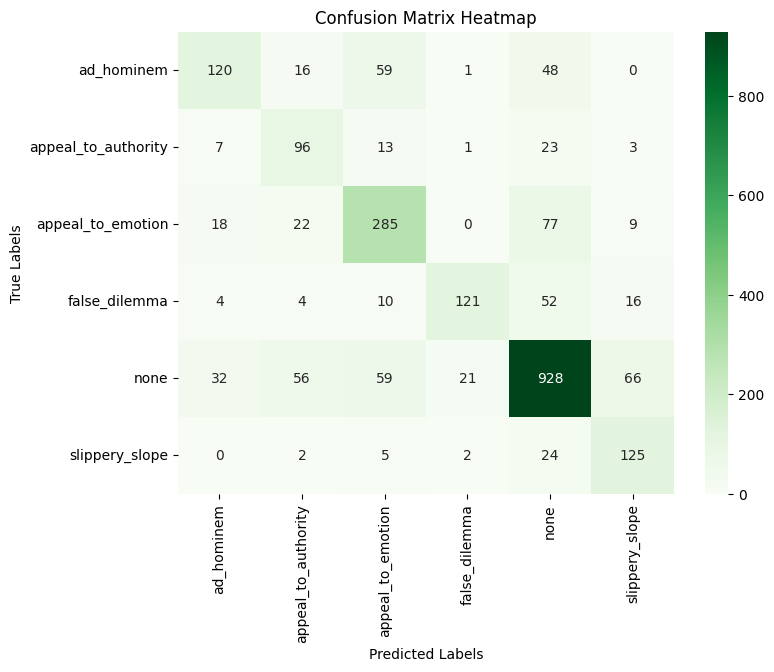

INFO:basic_functions:brier score


Multiclass Brier score: 0.4260909581083924


In [15]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")


INFO:root:predict on train_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.80      0.67      0.73       568
appeal_to_authority       0.59      0.73      0.65       333
  appeal_to_emotion       0.78      0.80      0.79       958
      false_dilemma       0.86      0.61      0.71       484
               none       0.84      0.84      0.84      2713
     slippery_slope       0.64      0.88      0.74       369

           accuracy                           0.79      5425
          macro avg       0.75      0.75      0.74      5425
       weighted avg       0.80      0.79      0.79      5425



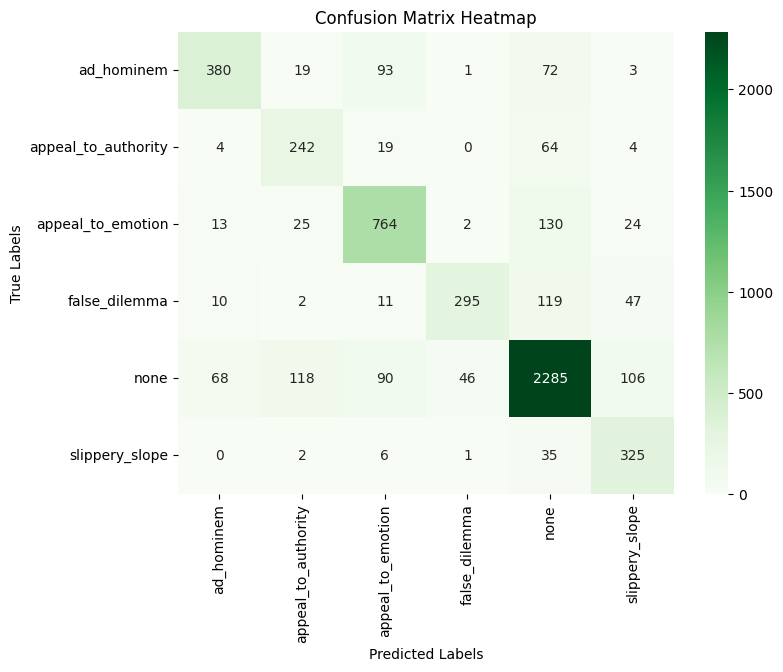

INFO:basic_functions:brier score


Multiclass Brier score: 0.3194050399598062


In [16]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")


In [ ]:
mlflow.end_run()

🏃 View run Distilbert Binary at: http://127.0.0.1:5001/#/experiments/823412171152425451/runs/cb539b160f0e4d8285c41e27e6f29a72
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/823412171152425451


### Save model

In [18]:
#save with pytorch
mlflow.pytorch.save_model(model, path=SAVE_PATH)

KeyboardInterrupt: 

### Error Analysis

In [19]:
df_error_test = get_error_analysis(test_output, encoded_test_dataset)

In [20]:
# get text, which is predicted false
print_error_df(df_error_test)

Example 0:
Text: If we don t resolve that issue all others become irrelevant
True Label: 4, Predicted Label: 3
Example 1:
Text: But it s not only women and it s not only this video that raises questions about his fitness to be our president because he has also targeted immigrants African Americans Latinos people with disabilities POWs Muslims and so many others So
True Label: 0, Predicted Label: 2
Example 2:
Text: Now that I think is one of the most serious sort of reversals or mixed messages that you could possibly send
True Label: 2, Predicted Label: 0
Example 3:
Text: The similarity between the ideas engraved on the Georgia Guidestones those espoused in the Earth Charter reflect the common origins of both Earth Charter serves as the basis for the UN document known as Agenda 21 Sustainable Development Depopulation
True Label: 2, Predicted Label: 1
Example 4:
Text: All of my friends are coming to my birthday party If Micah doesn t she might as well tell me that she doesn t like me
Tru

In [21]:
# get dataset, with most false predicted values
df_counts = df_error_test[['dataset', 'true_label', 'pred_label']].groupby(['dataset', 'true_label']).value_counts().reset_index()
df_counts.sort_values('count', ascending=False)

,dataset,true_label,pred_label,count
41,9,0,2,10
43,9,1,2,9
16,3,1,4,7
46,9,2,1,7
47,9,2,0,6
7,2,0,2,6
0,1,0,1,5
22,4,0,2,5
19,3,4,3,5
17,3,3,4,5
